In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [9]:
%%R
physeq.noSmall <- subset_samples(physeq,sample_sums(physeq)>=1500)

Error: Insufficient values in manual scale. 64 needed but only 48 provided.
In addition: There were 13 warnings (use warnings() to see them)


In [10]:
%%R
mdf = psmelt(physeq)

Error: Insufficient values in manual scale. 64 needed but only 48 provided.
In addition: Warning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels,  :
  duplicated levels in factors are deprecated


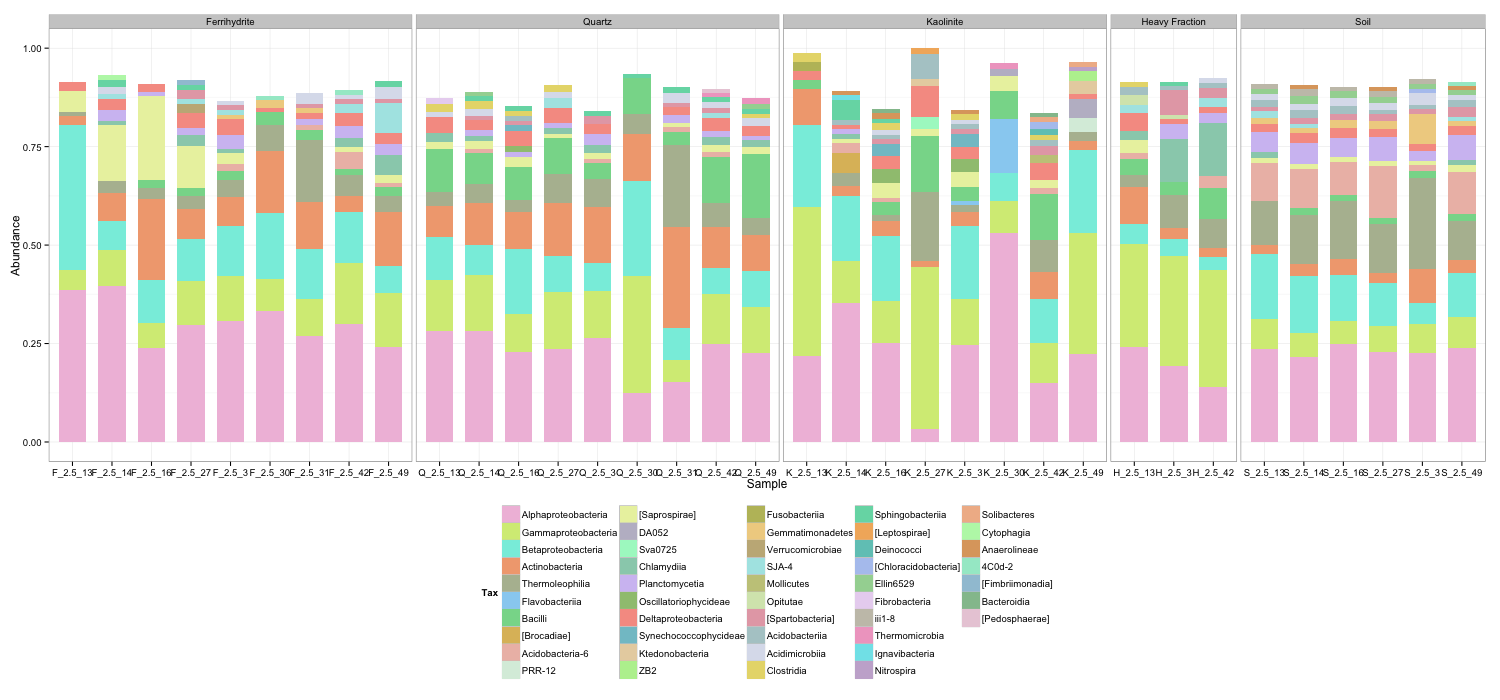

In [13]:
%%R -w 1500 -h 700

cutoff = 0.01
totabund = 00

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Class, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Month == 2.5) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

#p = p + theme(axis.text.x=theme_text(angle=-90))

p = p + theme_bw()

p = p + theme(legend.position="bottom")

p

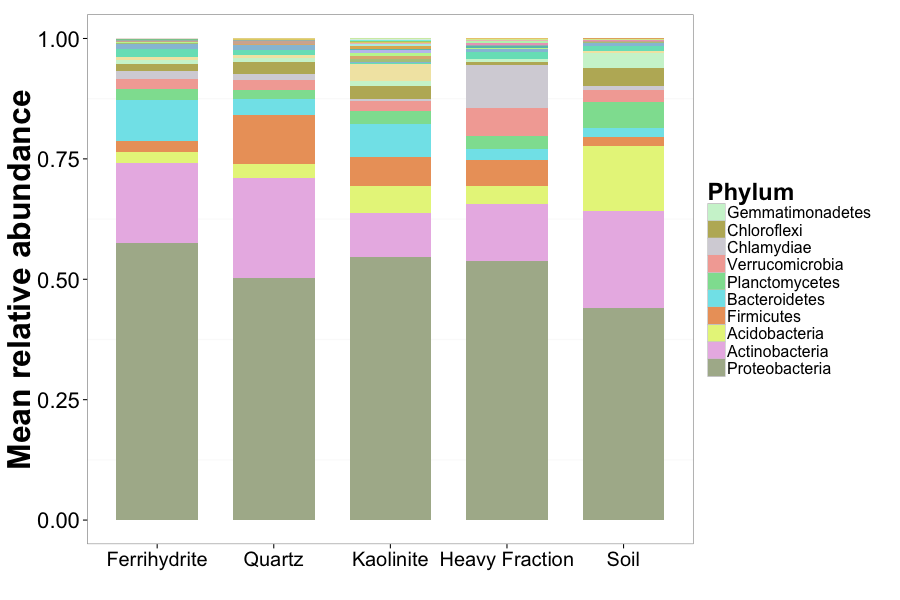

In [17]:
%%R -w 900 -h 600

cutoff = 0.00
totabund = 1500

d.plot = mdf %>%
    filter(Month==2.5)%>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, "Unidentified", paste(d.plot$Phylum))
d.plot$Phylum = ifelse(d.plot$Phylum=="unidentified", "Unidentified", paste(d.plot$Phylum))
d.plot = d.plot %>%
    group_by(Trtmt, Phylum, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Phylum) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Phylum)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order( Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

N=10
Phyla=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
p = p + scale_fill_manual(values = colors, breaks = Phyla)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 1, title = "Phylum", reverse="TRUE"))

#p = p + theme(axis.text.y=theme_text(angle=-90))

p = p + ylab("Mean relative abundance") + xlab("")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 20),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=22),
              axis.title.y = element_text(size = 32,vjust=1,face='bold'),
              legend.title = element_text(size=24),
              legend.text = element_text(size = 16))

p = p + theme(legend.position="right", panel.grid.major= element_blank())

p

In [18]:
%%R
ggsave(filename="RelabundPhylum16S.jpg", p, width=13, height=8.6)